In [2]:
from ts_inverse.attack_time_series_utils import SMAPELoss
import matplotlib.pyplot as plt
import pandas as pd
from ts_inverse.models import JitSeq2Seq_Predictor
from ts_inverse.workers.attack_worker import get_batch_sample_mapping
from ts_inverse.datahandler import get_datasets, ConcatDataset
from torch.utils.data import DataLoader

In [3]:
df_london_smartmeter = pd.read_csv("../data/LondonSmartMeter/london_smart_meters_dataset_without_missing_values_first_30_consumers.csv", index_col='Time', parse_dates=['Time'])
df_kddcup = pd.read_csv("../data/KDDCup_2018/kdd_cup_2018_dataset_without_missing_values.csv", index_col='Time', parse_dates=['Time'])
df_electricity_321_hourly = pd.read_csv("../data/Electricity321Hourly/electricity_hourly_dataset.csv", index_col='Time', parse_dates=['Time'])
df_electricity_370 = pd.read_csv("../data/Electricity370/LD2011_2014_first_40_consumers.csv", index_col='Time', parse_dates=['Time'])

In [ ]:
aux_dataset_config = {
    "dataset": "london_smartmeter",
    "columns": df_london_smartmeter.columns.tolist()[1:2],
    "train_stride": 1,
    "observation_days": 1,
    "future_days": 1,
    "normalize": "minmax",
}
# aux_dataset_config = {
#         'dataset': 'electricity_370',
#         'columns': df_electricity_370.columns.tolist()[4:5],
#         'train_stride': 1,
#         'observation_days': 1,
#         'future_days': 1,
#         'normalize': 'minmax',
# }

train_sets, val_sets, test_sets = get_datasets(**aux_dataset_config, split_ratio=0.2)
train_set = ConcatDataset(train_sets)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

train_loader = DataLoader(train_set, batch_size=(batch_size:=16), shuffle=True)


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
features = [0]
num_epochs = 10
teacher_forcing_ratio = 0.5
train_criterion = nn.MSELoss()
# Instantiate the encoder, decoder, and Seq2Seq model
model, optimizer = None, None
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs[:, :, features].to(device), targets[:, :, 0:1].to(device)

        if model is None or optimizer is None:
            model = JitSeq2Seq_Predictor(features, hidden_size=64, output_size=targets.shape[1]).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            model.train()

        # Zero the gradients
        optimizer.zero_grad()
        output_seq = model(inputs, targets, teacher_forcing_ratio)

        # Compute the loss
        # loss = F.mse_loss(output_seq, targets)
        loss = train_criterion(output_seq, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

print("Training complete.")


Device: mps
Epoch [1/10], Loss: 0.0108
Epoch [2/10], Loss: 0.0096
Epoch [3/10], Loss: 0.0091


KeyboardInterrupt: 

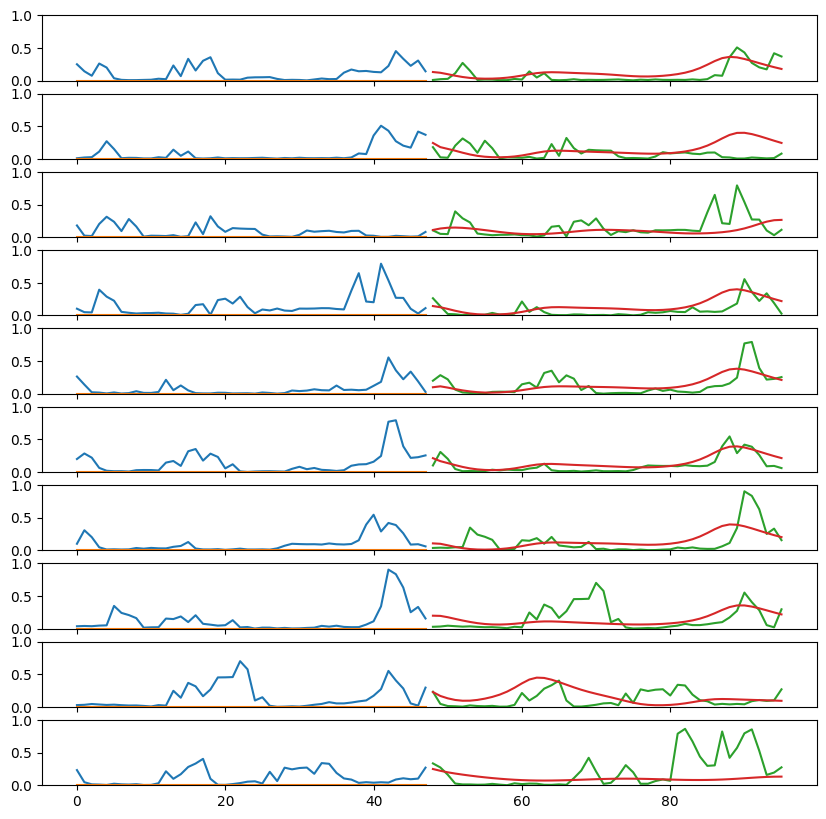

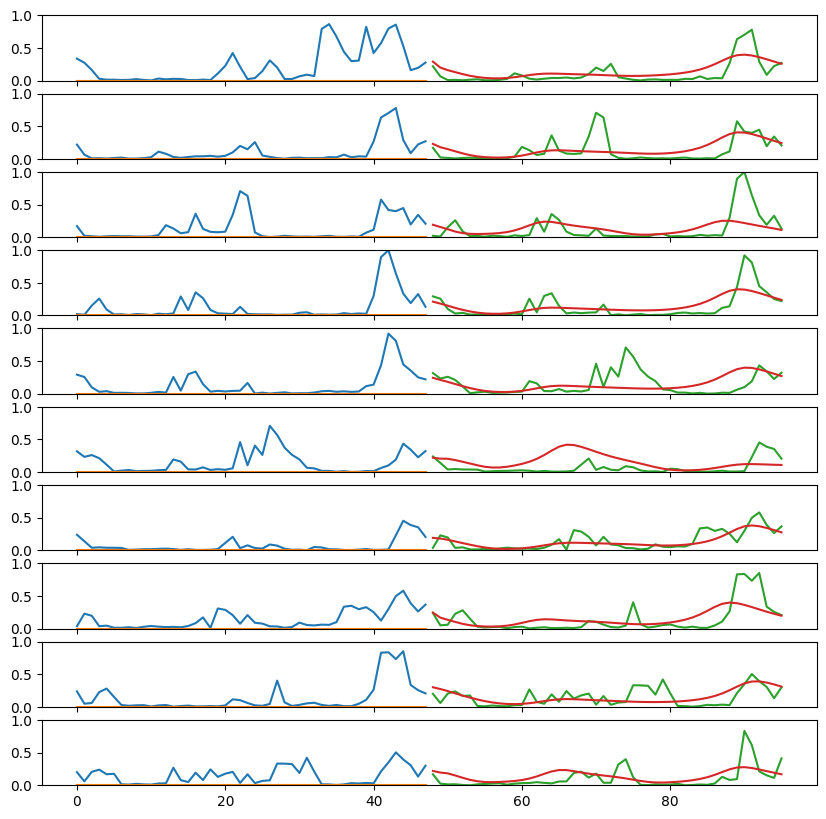

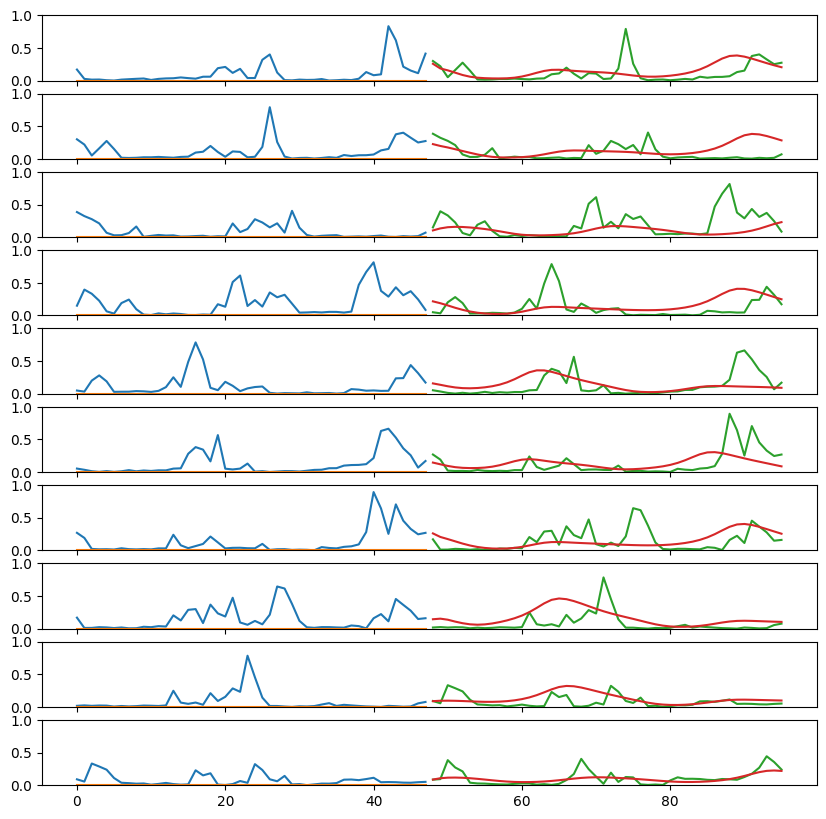

In [ ]:
def plot_original_and_dummy_data(sample_mapping, dummy_inputs, dummy_targets, batch_inputs, batch_targets):
    batch_size = batch_inputs.shape[0]
    original_x_axis = np.arange(0, batch_inputs.shape[1]+batch_targets.shape[1])
    fig, axes = plt.subplots(nrows=batch_size, figsize=(10, 1*batch_size), sharex=True)
    for i, j in enumerate(sample_mapping):
        ax = axes[i] if batch_size > 1 else axes
        ax.plot(original_x_axis[:batch_inputs.shape[1]], batch_inputs[i, :].detach().cpu().numpy(), label=f'Dataset Input ({i})')
        ax.plot(original_x_axis[:batch_inputs.shape[1]], dummy_inputs[j, :].detach().cpu().numpy(), label=f'Gradient Recovered Input ({j})')

        ax.plot(original_x_axis[batch_inputs.shape[1]:], batch_targets[i, :].detach().cpu().numpy(), label=f'Dataset Target ({i})')
        ax.plot(original_x_axis[batch_inputs.shape[1]:], dummy_targets[j, :].detach().cpu().numpy(), label=f'Gradient Recovered Target ({j})')
        ax.set_ylim(0, 1)
    plt.show()

val_set = ConcatDataset(val_sets)
val_loader = DataLoader(val_set, batch_size=10, shuffle=False)

model.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs[:, :, features].to(device), targets[:, :, 0:1].to(device)
        
        standard_mapping = np.arange(0, inputs.shape[0])
        prediction = model(inputs)
        zeross = torch.zeros_like(inputs)
        plot_original_and_dummy_data(standard_mapping, zeross, prediction, inputs, targets)

        if i > 1:
            break

In [ ]:
# Match the batch samples according to ground truth
def get_sample_mapping(d_x, d_y, a_x, a_y):
    standard_mapping = np.arange(0, a_x.shape[0])
    input_sample_mapping = get_batch_sample_mapping(a_x, d_x)
    target_sample_mapping = get_batch_sample_mapping(a_y, d_y)

    sample_mapping = np.arange(0, a_x.shape[0])
    if not (standard_mapping == input_sample_mapping).all():
        sample_mapping = input_sample_mapping
    if (standard_mapping == input_sample_mapping).all() and not (standard_mapping == target_sample_mapping).all():
        sample_mapping = target_sample_mapping
    return sample_mapping

attack_set = ConcatDataset(test_sets)
attack_data_loader = DataLoader(attack_set, batch_size=(attack_batch_size:=1), shuffle=False)

index = 10

# Initialize attack data & model
for attack_x, attack_y in attack_data_loader:
    attack_x, attack_y = attack_x[:, :, features].to(device), attack_y[:, :, 0:1].to(device)
    index -= 1
    if index == 0:
        break

In [ ]:
# Calculate loss and gradients
pred_y = model(attack_x).unsqueeze(-1)
original_y_loss = train_criterion(pred_y, attack_y)
original_y_loss.backward()
original_dy_dx = [param.grad.clone() for param in model.parameters()]

21.88519287109375 1.775227427482605 1.6449090242385864


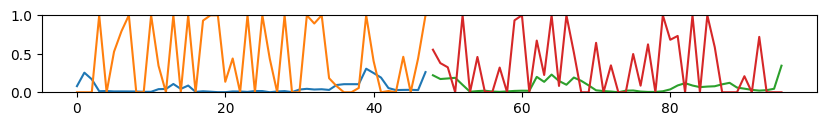

4.259124279022217 1.6091022491455078 1.682590126991272


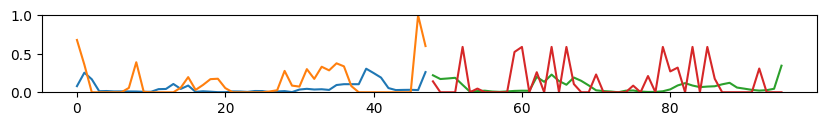

4.257772922515869 1.671444058418274 1.683747410774231


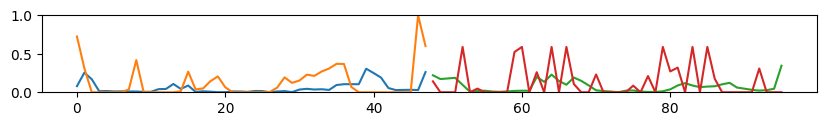

In [ ]:
dummy_x = torch.randn_like(attack_x)
dummy_y = torch.randn_like(attack_y)
dummy_x.requires_grad_(True)
dummy_y.requires_grad_(True)

dummy_optimizer = torch.optim.Adam([dummy_x, dummy_y], lr=0.005)

for i in range(5000):
    def closure():
        dummy_optimizer.zero_grad()

        # with torch.backends.cudnn.flags(enabled=False):
        dummy_out = model(dummy_x).unsqueeze(-1)
        dummy_y_loss = train_criterion(dummy_out, dummy_y)
        dummy_dy_dx = torch.autograd.grad(dummy_y_loss, model.parameters(), create_graph=True)
        dy_dx_loss = sum((d_g - o_g).abs().sum() for d_g, o_g in zip(dummy_dy_dx, original_dy_dx))
        
        dy_dx_loss.backward()

        return dy_dx_loss

    dy_dx_loss = dummy_optimizer.step(closure)

    if i % 2 == 0:
        dummy_x.data.clamp_(0, 1)
        dummy_y.data.clamp_(0, 1)

    if i % 1000 == 0:
        with torch.no_grad():
            sample_mapping = get_sample_mapping(dummy_x, dummy_y, attack_x, attack_y)
            print(dy_dx_loss.item(), SMAPELoss(dummy_x[sample_mapping], attack_x).item(), SMAPELoss(dummy_y[sample_mapping], attack_y).item())
            plot_original_and_dummy_data(sample_mapping, dummy_x, dummy_y, attack_x, attack_y)